In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import autograd.numpy as np
import autograd.scipy as sp
import scipy as osp
import inspect
import os
import sys
import time

import paragami
import vittles

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib
import bnpgmm_runjingdev.functional_sensitivity_lib as fun_sens_lib 

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
fit_dir = '/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/fits'

fitfile = os.path.join(
    fit_dir,
    'transformed_gene_regression_df4_degree3_genes700_' +
    'num_components40_inflate1.0_shrunkTrue_alpha2.0_fit.npz')
with np.load(fitfile) as infile:
    gmm_params_pattern = paragami.get_pattern_from_json(
        str(infile['gmm_params_pattern_json']))
    opt_gmm_params = gmm_params_pattern.fold(
        infile['opt_gmm_params_flat'], free=False)
    prior_params_pattern = paragami.get_pattern_from_json(
        str(infile['prior_params_pattern_json']))
    prior_params = prior_params_pattern.fold(
        infile['prior_params_flat'], free=False)
    kl_hess = infile['kl_hess']
    df = infile['df']
    degree = infile['degree']
    datafile = str(infile['datafile'])
    num_components = int(infile['num_components'])

reg_params = dict()
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    inflate_cov = infile.get('inflate_cov', 0)
    eb_shrunk = infile.get('eb_shrunk', False)

num_genes = reg_params['beta_mean'].shape[0]

analysis_name = \
    ('transformed_gene_regression_df{}_degree{}_genes{}_' +
     'num_components{}_inflate{}_shrunk{}_refit').format(
    df, degree, num_genes, num_components, inflate_cov, eb_shrunk)

In [3]:
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

print('Setting preconditioner...')
gmm.get_kl_conditioned.set_preconditioner_with_hessian(
    hessian=kl_hess, ev_min=1e-6)
print('Done.')

Setting preconditioner...
Done.


In [4]:
assert(len(np.unique(prior_params['probs_alpha'])) == 1)
alpha0 = np.unique(prior_params['probs_alpha'])[0]

In [7]:
log_phi_desc = 'expit'
log_phi = gmm_lib.get_log_phi(log_phi_desc)

def phi(logit_v):
    return np.exp(log_phi(logit_v))

logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 10 * log_phi(logit_v) / log_phi_max

phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [8]:
prior_perturbation_visualization = fun_sens_lib.PriorPerturbation(
    vb_params_dict = opt_gmm_params, 
    alpha0 = alpha0,
    gh_loc = gmm.gh_loc, 
    gh_weights = gmm.gh_weights, 
    log_phi = rescaled_log_phi,
    logit_v_ub=8,
    logit_v_lb = -8)

Text(0.5, 1.0, 'Priors in logit space')

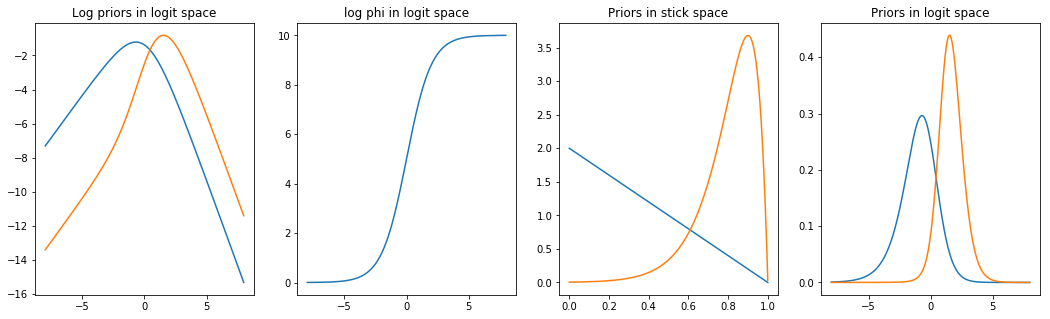

In [9]:
prior_perturbation_visualization.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation_visualization.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation_visualization.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation_visualization.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation_visualization.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation_visualization.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation_visualization.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation_visualization.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [14]:
# Save for visualization in the poster and presentation

prior_perturbation_visualization.set_epsilon(1.0)
viz_filename = 'prior_functional_perturbation_shape_{}.npz'.format(log_phi_desc)

prior_viz_dict = {}
prior_viz_dict['logit_v_grid'] = logit_v_grid
prior_viz_dict['v_grid'] = v_grid
prior_viz_dict['log_p0_logit'] = prior_perturbation_visualization.get_log_p0_logit(logit_v_grid)
prior_viz_dict['log_p1_logit'] = prior_perturbation_visualization.get_log_pc_logit(logit_v_grid)
prior_viz_dict['log_p0'] = prior_perturbation_visualization.get_log_p0(v_grid)
prior_viz_dict['log_p1'] = prior_perturbation_visualization.get_log_pc(v_grid)
prior_viz_dict['log_phi'] = prior_perturbation_visualization.log_phi(logit_v_grid)

print('Saving to {}'.format(os.path.join(fit_dir, viz_filename)))
np.savez_compressed(os.path.join(fit_dir, viz_filename), **prior_viz_dict)

Saving to /home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/fits/prior_functional_perturbation_shape_expit.npz


In [10]:
prior_pert = gmm_lib.PriorPerturbation(log_phi, gmm.gh_loc, gmm.gh_weights)
prior_pert.get_e_log_perturbation(opt_gmm_params)

init_x = gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True)

hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon:
        prior_pert.get_e_log_perturbation_epsilon,
    argnums=0, patterns=gmm.gmm_params_pattern, free=True)

# Sanity check.  The first two should be the same and the last one different.
gmm.set_perturbation_fun(None)
prior_pert.set_epsilon(1.0)
print(gmm.get_params_kl_flat(init_x))

gmm.set_perturbation_fun(prior_pert.get_e_log_perturbation)
prior_pert.set_epsilon(0.0)
print(gmm.get_params_kl_flat(init_x))

prior_pert.set_epsilon(1.0)
print(gmm.get_params_kl_flat(init_x))

-9776.818150922472
-9776.818150922472
-9785.018630100394


In [ ]:
epsilon = 0.1
prior_pert.set_epsilon(epsilon)

init_x = gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True)

print('Optimizing...')
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x, verbose=True, kl_hess=kl_hess)
opt_time = time.time() - tic
print('Done.')
print('Re-optimization time: {} seconds'.format(opt_time))

In [ ]:
reopt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)

In [ ]:
e_z0 = gmm.get_e_z(opt_gmm_params)
e_z1 = gmm.get_e_z(reopt_gmm_params)
np.max(np.abs(e_z0 - e_z1))

In [ ]:
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_num_large_clusters_from_ez
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_number_clusters_from_logit_sticks

n_samples = 10000
threshold = 1
predictive = True

unif_samples = None
unv_norm_samples = None
if not predictive:
    unif_samples = np.random.random((gmm.num_obs, n_samples))
else:
    unv_norm_samples = np.random.normal(
        0, 1, size = (n_samples, num_components - 1))

def get_posterior_quantity(gmm_params):
    if not predictive:
        e_z = gmm.get_e_z(gmm_params)
        e_num, var_num = get_e_num_large_clusters_from_ez(
            e_z,
            threshold = threshold,
            n_samples = None,
            unif_samples = unif_samples)
    else:
        e_num = \
            get_e_number_clusters_from_logit_sticks(
                gmm_params['stick_propn_mean'],
                gmm_params['stick_propn_info'],
                n_obs = gmm.num_obs,
                threshold = threshold,
                n_samples = None,
                unv_norm_samples = unv_norm_samples)
    return e_num

get_posterior_quantity(opt_gmm_params)

In [ ]:
e_num0 = get_posterior_quantity(opt_gmm_params)
e_num1 = get_posterior_quantity(reopt_gmm_params)
print('Refit e:\t{}\nOrig e: \t{}\nDifference:\t{}\n'.format(
    e_num1, e_num0, e_num1 - e_num0))